In [4]:
from importlib import reload
from variaIa.variaIa import baserate

In [15]:
import pandas as pd

d = pd.read_csv('../Data/data_cheat.csv',
                sep=' ', index_col = 'CID')

import numpy as np
import iminuit as im
from scipy.stats import poisson
from astropy.cosmology import Planck15 as cdata
import matplotlib.pyplot as plt
plt.style.use('classic')
import random
import ipywidgets as ipw

su = ipw.Dropdown(options=['SDSS','SNLS','PS1','HST'],
                  description='Survey:',
                  value = 'SNLS')

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple'} 

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

def set_datap(su):
    global datap
    datap = np.sort(surv[su].zCMB.values)
    
int_datap = ipw.interactive(set_datap, su = su)
display(int_datap)

interactive(children=(Dropdown(description='Survey:', index=1, options=('SDSS', 'SNLS', 'PS1', 'HST'), value='…

In [6]:
nb = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins:', continuous_update=False)

def set_bins(nb):
    global bins, bord, counts
    bord = np.asarray(np.histogram(datap, bins = nb)[1])
    bins = np.asarray([[bord[i],bord[i+1]] for i in range(len(bord)-1)]).T
    counts = np.histogram(datap, bord)[0]
    
int_bins = ipw.interactive(set_bins, nb = nb)
display(int_bins)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins:', max=30, min=3), Outpu…

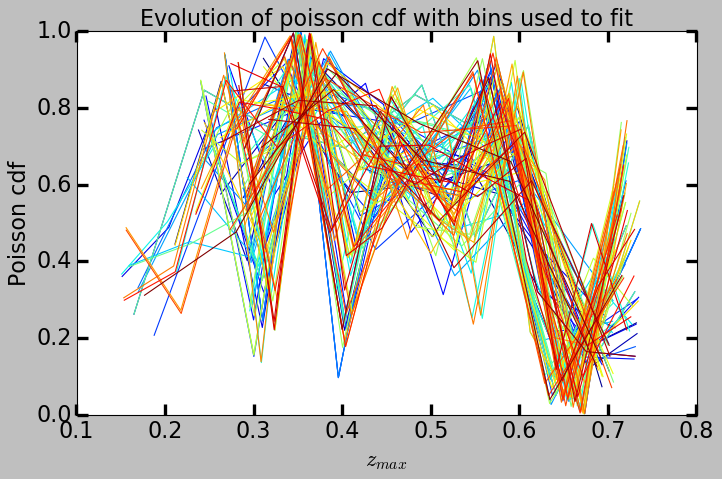

In [31]:
reload(baserate)

def pshow_r_SNLS(rawdata, guess, loops):
    """ """
    global x, y, nb_bins_r

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = [10,6])

    ndata = rawdata[np.where(rawdata[np.where(rawdata>0.3)]<0.8)]
    dl = len(ndata)

    nbase_r = BaseRateModel()
    nrate_r = RateFitter()

    x = []
    y = []
    nb_bins_r = []

    for i in range(loops):
        ndata_r_a = np.random.randint(0,10)
        ndata_r_b = np.random.randint(dl-10,dl+1)
        ndata_r = ndata[ndata_r_a:ndata_r_b+1]
        nb_bins_r.append(np.random.randint(5,13))
        nbord_r = np.asarray(np.histogram(ndata_r, bins = nb_bins_r[i])[1])
        nbins_r = np.asarray([[nbord_r[i],nbord_r[i+1]] for i in range(len(nbord_r)-1)]).T
        ncounts_r = np.histogram(ndata_r, nbord_r)[0]

        nrate_r.set_data(ncounts_r, nbins_r)
        nrate_r.set_model(nbase_r)
        #ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
        nrate_r.fit(a_guess = guess)

        x.append(nrate_r._central_redshiftranges)
        y.append(nrate_r.model.get_cumuprob(nrate_r.counts,\
                                            nrate_r.redshift_ranges))

        plt.plot(x[i],y[i])

    ax = plt.gca()
    ax.tick_params(axis = 'both',
                   direction = 'in',
                   length = 10, width = 3,
                   labelsize = 20,
                   which = 'both',
                   top = True, right = True)
    plt.xlabel('$z_{max}$', fontsize = 20)
    plt.ylabel('Poisson cdf', fontsize = 20)

    plt.title('Evolution of poisson cdf with bins used to fit', fontsize = 20)

    plt.show()

## Base model

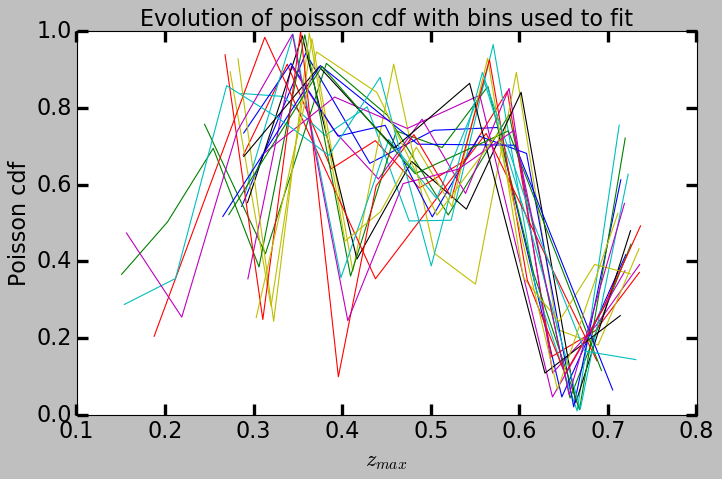

In [14]:
reload(baserate)

base = baserate.BaseRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(counts, bins)
ratefitter.set_model(base)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
#ratefitter.fit(a_guess = 0.2)
#_ = ratefitter.show(add_proba = True)
baserate.pshow_r_SNLS(datap, 0.2, 20)

## Expo Model

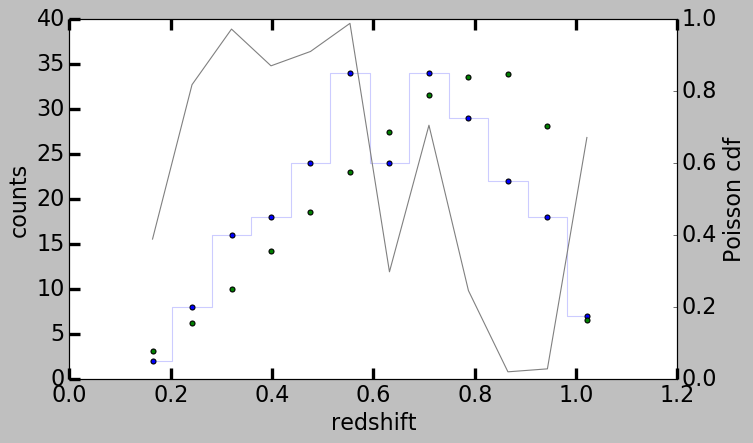

In [51]:
reload(baserate)

expo = baserate.ExpoRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(counts, bins)
ratefitter.set_model(expo)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2, b_guess = 1, zmax_guess = 0.7, zc_guess = 1e-1,\
               #b_fixed = True, zmax_fixed = True, zc_fixed = True\
              )
_ = ratefitter.show(add_proba = True)

In [52]:
expo.parammissed

{'b': 5316.234720963694, 'zmax': 0.7486620139677895, 'zc': 0.07845836687013252}

## Const model

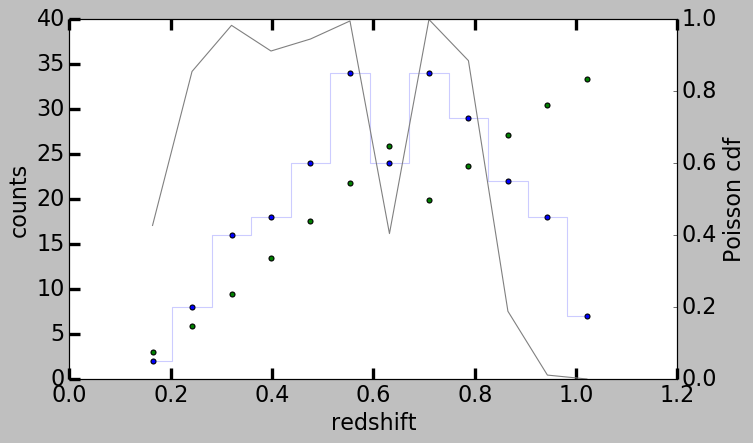

In [37]:
reload(baserate)

const = baserate.ConstRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(counts, bins)
ratefitter.set_model(const)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges<0.7)
ratefitter.fit(a_guess = 0.2, zmax_guess = 0.7,\
               zmax_fixed = True)
_ = ratefitter.show(add_proba = True)

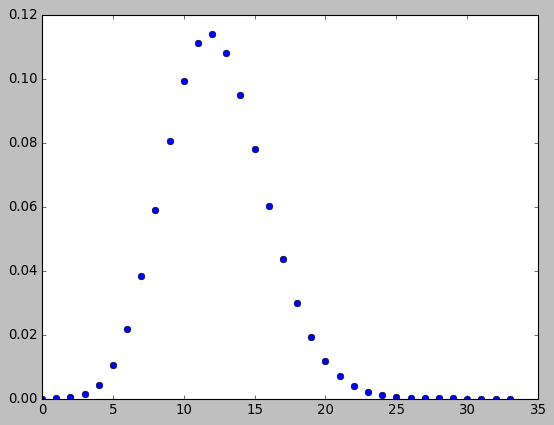

In [29]:
plt.plot(np.arange(0,np.max(data)), poisson.pmf(np.arange(0,np.max(data)),base.get_expectedrate(ratefitter.redshift_ranges)[2]), 'bo')